# Latent space

In [1]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

#Libraries
import yaml
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    RandomHorizontalFlip,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from datasets import load_dataset
from diffusers import (
    UNet2DModel,
    DDPMScheduler,
    AutoencoderKL,
)    
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

# extra
import pandas as pd
from PIL import Image
import csv
from packaging import version
import matplotlib.pyplot as plt

In [2]:
# create a dataset class for our breast images
class breast_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path: Path, images_dir: Path, transform=None):
        """_summary_

        Args:
            csv_path (Path): path to the csv file with the filenames
            images_dir (Path): path to the folder with the images
            transform (function, optional): transformation function. Usually pytorch.Transform. Defaults to None.
        """
        self.names = pd.read_csv(csv_path, header=None) # read csv file
        self.images_dir = images_dir # path to image folder
        self.transform = transform # transform to apply to images
    
    def __len__(self):
        """returns the length of the dataset

        Returns:
            int: length of the dataset
        """
        return len(self.names)
    
    def __getitem__(self, idx: int):
        """returns the image at index idx

        Args:
            idx (int): index in the csv file

        Returns:
            PIL.Image: PIL image
        """
        img_path = self.images_dir / self.names.iloc[idx, 0] # get image path
        image = Image.open(img_path) # open image
        # image = np.array(image, dtype=np.float32) # convert to numpy array
        if self.transform: # apply transform if it exists
            image = self.transform(image)
            
        return image
    
    def set_transform(self, transform):
        """set the transform to apply to the images

        Args:
            transform (function): transform to apply to the images
        """
        self.transform = transform

    def __repr__(self) -> str:
        return f"({len(self)} images)"

def load_breast_dataset(folder_dir:Path):
    # get directory name
    folder_name = folder_dir.name
    # check if the csv file with the filenames already exists
    csv_path = folder_dir.parent.parent / 'filenames' / f'{folder_name}.csv'
    if not csv_path.exists(): # if not, create it
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            for filename in os.listdir(folder_dir):
                if filename.endswith(".png"):
                    writer.writerow([filename])
    # now we can create the dataset
    dataset = breast_dataset(csv_path, images_dir= folder_dir)
    
    return dataset    


In [3]:
# GPU and config
selected_gpu = 0 #select the GPU to use
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}\n')
# load the config file
config_path = repo_path / 'experiments/unconditional_vae/config.yaml'
with open(config_path) as file: # expects the config file to be in the same directory
        config = yaml.load(file, Loader=yaml.FullLoader)

### 1. Dataset loading and preprocessing
# Dataset loading
data_dir = repo_path / config['processing']['dataset']
dataset = load_breast_dataset(data_dir)
# Define data augmentations
class ToFloat32Tensor(object):
    """
    Converts a PIL Image to a PyTorch tensor with dtype float32, and normalises it.
    """
    def __call__(self, image):
        # Convert PIL Image to PyTorch tensor with dtype float32
        tensor = ToTensor()(image).float()/config['processing']['normalisation_value']
        return tensor

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToFloat32Tensor(),  # Convert to tensor (0, 1)
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)
#set the transform function to the dataset
dataset.set_transform(preprocess)
# Create the dataloader
# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers= config['processing']['num_workers'], shuffle=False # need order
)

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.requires_grad_(False)
# send vae to accelerator
vae.to(device);

The device is: cuda:0



In [10]:
summary(vae.encoder, input_size=(3,512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 512, 512]           3,584
         GroupNorm-2        [-1, 128, 512, 512]             256
              SiLU-3        [-1, 128, 512, 512]               0
            Conv2d-4        [-1, 128, 512, 512]         147,584
         GroupNorm-5        [-1, 128, 512, 512]             256
              SiLU-6        [-1, 128, 512, 512]               0
           Dropout-7        [-1, 128, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]         147,584
     ResnetBlock2D-9        [-1, 128, 512, 512]               0
        GroupNorm-10        [-1, 128, 512, 512]             256
             SiLU-11        [-1, 128, 512, 512]               0
           Conv2d-12        [-1, 128, 512, 512]         147,584
        GroupNorm-13        [-1, 128, 512, 512]             256
             SiLU-14        [-1, 128, 5

In [4]:
# get next batch
batch = next(iter(train_dataloader))
batch = batch.to(device)

# # read csv file with the filenames
# csv_path = repo_path / 'data/filenames/breast10p.csv'
# names = pd.read_csv(csv_path, header=None)
# name = names.iloc[i].item()
encoder_hidden_states = text_encoder(batch["input_ids"])[0]
# extract vae version
    

In [5]:
# original batch expansion
batch_exp = batch.expand(-1, 3, -1, -1) # expand the batch to have three channels
# add extra two channels with zeros
batch_2 = torch.cat((batch, torch.zeros(batch.shape[0], 2, batch.shape[2], batch.shape[3]).to(device)), dim=1)

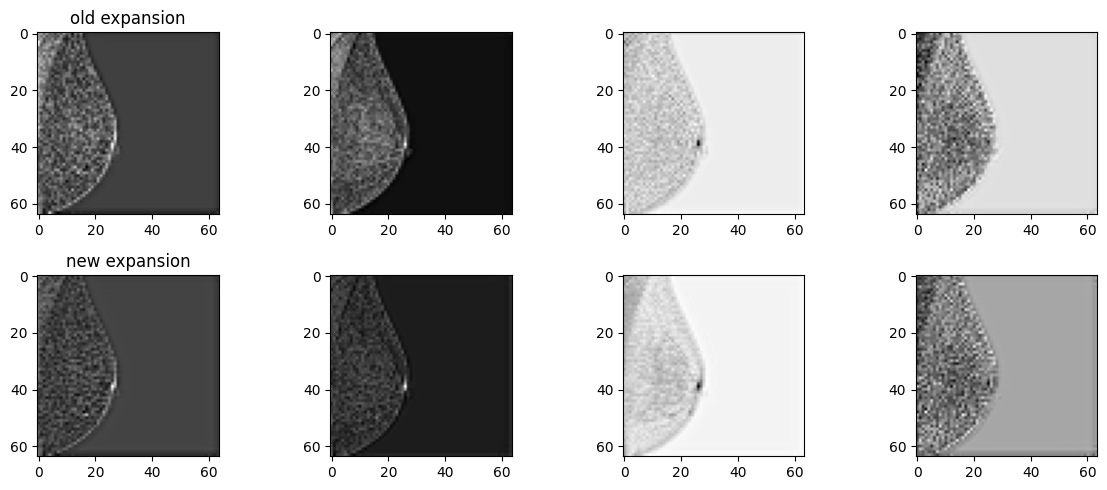

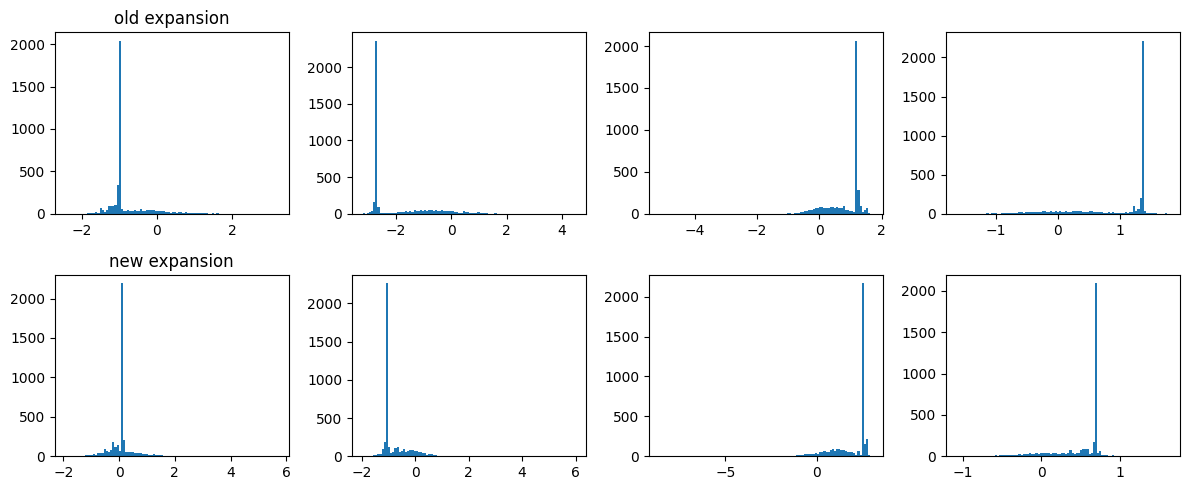

In [8]:
# old expansion
latents_exp = vae.encode(batch_exp).latent_dist.sample() # sample from the latent distribution
latents_exp = latents_exp * vae.config.scaling_factor # scale the latents so they are around -1 and 1 (but not exactly)

# new expansion
latents_2 = vae.encode(batch_2).latent_dist.sample() # sample from the latent distribution
latents_2 = latents_2 * vae.config.scaling_factor # scale the latents so they are around -1 and 1 (but not exactly)



# show latents
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
for i in range(4):
    axs[0,i].imshow(latents_exp[0, i].detach().cpu().numpy(), cmap='gray')
    axs[1,i].imshow(latents_2[0, i].detach().cpu().numpy(), cmap='gray')
axs[0,0].set_title('old expansion')
axs[1,0].set_title('new expansion')
fig.tight_layout()
# show histogram of the latents
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
for i in range(4):
    axs[0,i].hist(latents_exp[0, i].detach().cpu().numpy().flatten(), bins=100)
    axs[1,i].hist(latents_2[0, i].detach().cpu().numpy().flatten(), bins=100)
axs[0,0].set_title('old expansion')
axs[1,0].set_title('new expansion')
# give extra space between subplots
fig.tight_layout()


# # save latents as torch tensor withoput gradients
# latents = latents.detach()
# torch.save(latents, repo_path / 'data/images/breast10p_latents'/f'{Path(name).stem}.pt')

## Reconstruction

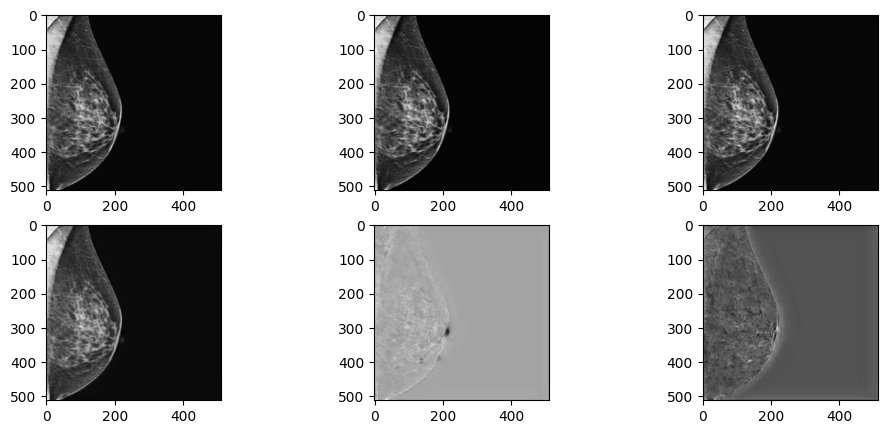

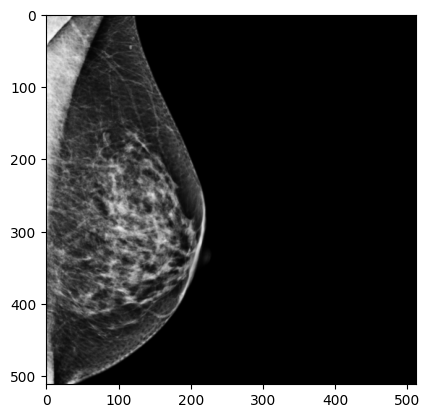

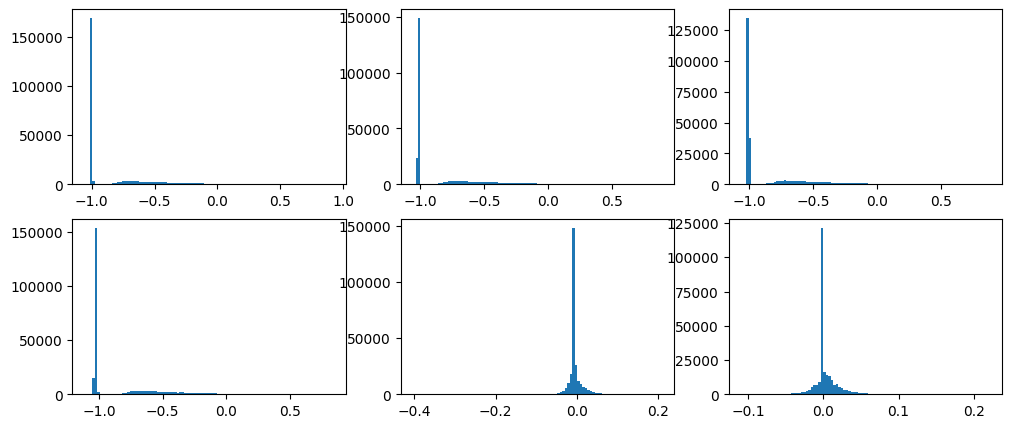

In [11]:
# old expansion
decompress_exp = latents_exp/vae.config.scaling_factor
decompress_exp = vae.decode(decompress_exp).sample
# new expansion
decompress_2 = latents_2/vae.config.scaling_factor
decompress_2 = vae.decode(decompress_2).sample

# show decompressed images
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
for i in range(3):
    axs[0,i].imshow(decompress_exp[0, i].detach().cpu().numpy(), cmap='gray')
    axs[1,i].imshow(decompress_2[0, i].detach().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(batch[0,0].detach().cpu().numpy(), cmap='gray')

# show histogram decompressed images
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
for i in range(3):
    axs[0,i].hist(decompress_exp[0, i].detach().cpu().numpy().flatten(), bins=100)
    axs[1,i].hist(decompress_2[0, i].detach().cpu().numpy().flatten(), bins=100)


# # save decompressed images individually
# for i in range(3):
#     plt.imsave(f'decompressed_{i}.png', decompress_exp[0, i].detach().cpu().numpy(), cmap='gray')
#     plt.imsave(f'decompressed_2_{i}.png', decompress_2[0, i].detach().cpu().numpy(), cmap='gray')

(array([1.20000e+01, 4.10000e+02, 1.69392e+05, 3.18200e+03, 2.17000e+02,
        2.91000e+02, 3.91000e+02, 3.97000e+02, 4.22000e+02, 5.64000e+02,
        6.66000e+02, 8.70000e+02, 1.28700e+03, 1.81300e+03, 2.36400e+03,
        2.83400e+03, 3.16800e+03, 3.14200e+03, 3.04200e+03, 2.83600e+03,
        2.91600e+03, 2.87200e+03, 2.71900e+03, 2.56300e+03, 2.59000e+03,
        2.34900e+03, 2.25100e+03, 2.21400e+03, 2.06100e+03, 2.09600e+03,
        1.98200e+03, 1.91200e+03, 1.82600e+03, 1.74100e+03, 1.61300e+03,
        1.51800e+03, 1.47300e+03, 1.40000e+03, 1.25900e+03, 1.32000e+03,
        1.23900e+03, 1.14700e+03, 1.09300e+03, 1.01200e+03, 9.35000e+02,
        8.75000e+02, 8.73000e+02, 8.09000e+02, 7.60000e+02, 7.02000e+02,
        6.87000e+02, 6.00000e+02, 5.84000e+02, 5.46000e+02, 5.52000e+02,
        5.69000e+02, 4.99000e+02, 4.84000e+02, 4.77000e+02, 4.33000e+02,
        4.08000e+02, 3.83000e+02, 4.09000e+02, 4.04000e+02, 3.68000e+02,
        3.82000e+02, 3.50000e+02, 3.49000e+02, 3.51

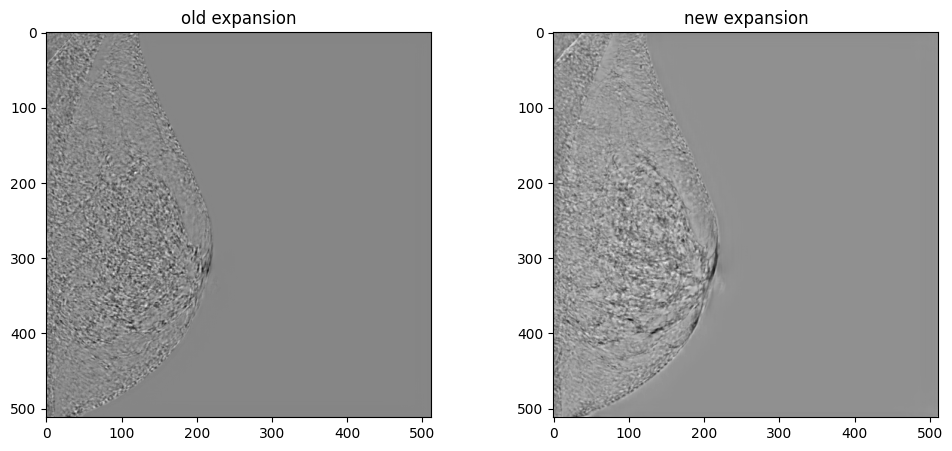

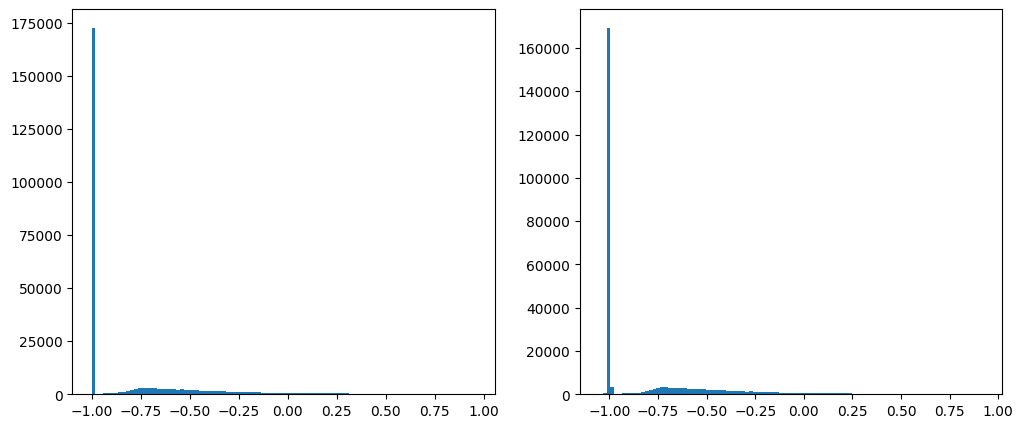

In [12]:
# check substractions between the two decompressed images with the original image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow((decompress_exp[0, 0].detach().cpu().numpy() - batch[0,0].detach().cpu().numpy()), cmap='gray')
axs[1].imshow((decompress_2[0, 0].detach().cpu().numpy() - batch[0,0].detach().cpu().numpy()), cmap='gray')
# titles
axs[0].set_title('old expansion')
axs[1].set_title('new expansion')

# show histogram of original image and decompress_exp
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(batch[0,0].detach().cpu().numpy().flatten(), bins=100)
axs[1].hist(decompress_exp[0, 0].detach().cpu().numpy().flatten(), bins=100)


# Text encoder

In [5]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # experiment path
# visible GPUs
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import argparse
import yaml
import hashlib
import itertools
import logging
import math
# import warnings
from pathlib import Path
from typing import Optional

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig
from datasets import load_dataset
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    UNet2DConditionModel,
    DDIMScheduler,
)
import random
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available
from torchsummary import summary


if is_wandb_available():
    import wandb

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.15.0.dev0")

logger = get_logger(__name__)


def log_validation(text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, epoch, guidance_scale=7.5):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    # create pipeline (note: unet and vae are loaded again in float32)
    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        vae=vae,
        revision=args.revision,
        torch_dtype=weight_dtype,
        safety_checker=None,
    )
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    # run inference
    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)
    images = []
    for _ in range(args.num_validation_images):
        with torch.autocast("cuda"):
            image = pipeline(args.validation_prompt, num_inference_steps=25, generator=generator, guidance_scale=guidance_scale).images[0]
        images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )

    del pipeline
    torch.cuda.empty_cache()


def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")


def collate_fn(examples, with_prior_preservation=False):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.cat(input_ids, dim=0)

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch


class PromptDataset(Dataset):
    """A simple dataset to prepare the prompts to generate class images on multiple GPUs.
    The get item trturns example dictionaty with the prompt and the index of the example.
    """

    def __init__(self, prompt, num_samples):
        """init with promt and number of samples

        Args:
            prompt (str): text prompt
            num_samples (int): num of samples
        """
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example


def get_full_repo_name(model_id: str, organization: Optional[str] = None, token: Optional[str] = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

In [2]:
# read and set config file
config_path = 'config_file.yaml' # configuration file path (beter to call it from the args parser)
with open(config_path) as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)
args = argparse.Namespace(**config) # parse the config file

logging_dir = Path(args.output_dir, args.logging_dir) # path for logging

accelerator_project_config = ProjectConfiguration(total_limit=args.checkpoints_total_limit)
accelerator = Accelerator( # start accelerator
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision, 
    log_with=args.report_to, # logger (tb or wandb)
    logging_dir=logging_dir, # defined above
    project_config=accelerator_project_config, # project config defined above
)

if args.report_to == "wandb":
    if not is_wandb_available():
        raise ImportError("Make sure to install wandb if you want to use it for logging during training.")

# Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
# This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
# TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
    raise ValueError(
        "Gradient accumulation is not supported when training the text encoder in distributed training. "
        "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
    )

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

# Generate class images if prior preservation is enabled.
if args.with_prior_preservation:
    class_images_dir = Path(args.class_data_dir) # get path of class images
    if not class_images_dir.exists(): # create folder if not exists
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir())) # count how many images there are

    if cur_class_images < args.num_class_images: # if there are less images than needed
        # define dtype for prior generation
        torch_dtype = torch.float16 if accelerator.device.type == "cuda" else torch.float32
        if args.prior_generation_precision == "fp32":
            torch_dtype = torch.float32
        elif args.prior_generation_precision == "fp16":
            torch_dtype = torch.float16
        elif args.prior_generation_precision == "bf16":
            torch_dtype = torch.bfloat16
        pipeline = DiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path, # from same pretrained model as main model
            vae=AutoencoderKL.from_pretrained(
                args.pretrained_vae_name_or_path or args.pretrained_model_name_or_path,
                subfolder=None if args.pretrained_vae_name_or_path else "vae",
                revision=None if args.pretrained_vae_name_or_path else args.revision,
                torch_dtype=torch_dtype
            ), 
            torch_dtype=torch_dtype,
            safety_checker=None, # no safety checker
            revision=args.revision, # The specific model version to use
        )
        pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = args.num_class_images - cur_class_images # number of images still needed
        logger.info(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(args.class_prompt, num_new_images) # define prompt dataset, returns prompt and index as item
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=args.sample_batch_size)

        sample_dataloader = accelerator.prepare(sample_dataloader) # dataloader for accelerator
        pipeline.to(accelerator.device) # send pipeline to accelerator device

        for example in tqdm(sample_dataloader, desc="Generating class images", disable=not accelerator.is_local_main_process):
            images = pipeline(example["prompt"], num_inference_steps=20).images # generate image(s) from prompt

            for i, image in enumerate(images): # for each image in the batch
                hash_image = hashlib.sha1(image.tobytes()).hexdigest() # create hash as unique identifier
                image_filename = class_images_dir / f"{example['index'][i] + cur_class_images}-{hash_image}.jpg"
                image.save(image_filename)

        del pipeline # free memory when done
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Handle the repository creation
if accelerator.is_main_process:
    if args.push_to_hub:
        if args.hub_model_id is None:
            repo_name = get_full_repo_name(Path(args.output_dir).name, token=args.hub_token)
        else:
            repo_name = args.hub_model_id
        create_repo(repo_name, exist_ok=True, token=args.hub_token)
        repo = Repository(args.output_dir, clone_from=repo_name, token=args.hub_token)

        with open(os.path.join(args.output_dir, ".gitignore"), "w+") as gitignore:
            if "step_*" not in gitignore:
                gitignore.write("step_*\n")
            if "epoch_*" not in gitignore:
                gitignore.write("epoch_*\n")
    elif args.output_dir is not None: # create output directory if it doesn't exist
        os.makedirs(args.output_dir, exist_ok=True)

# Load the tokenizer
if args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, revision=args.revision, use_fast=False)
elif args.pretrained_model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
        use_fast=False,
    )

# import correct text encoder class: only ROBERTA or CLIP
text_encoder_cls = import_model_class_from_model_name_or_path(args.pretrained_model_name_or_path, args.revision)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)

#vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision)
vae=AutoencoderKL.from_pretrained(
                args.pretrained_vae_name_or_path or args.pretrained_model_name_or_path,
                subfolder=None if args.pretrained_vae_name_or_path else "vae",
                revision=None if args.pretrained_vae_name_or_path else args.revision,
            )

unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# `accelerate` 0.16.0 will have better support for customized saving
if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
    # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
    def save_model_hook(models, weights, output_dir):
        for model in models:
            sub_dir = "unet" if type(model) == type(unet) else "text_encoder"
            model.save_pretrained(os.path.join(output_dir, sub_dir))

            # make sure to pop weight so that corresponding model is not saved again
            weights.pop()

    def load_model_hook(models, input_dir):
        while len(models) > 0:
            # pop models so that they are not loaded again
            model = models.pop()

            if type(model) == type(text_encoder):
                # load transformers style into model
                load_model = text_encoder_cls.from_pretrained(input_dir, subfolder="text_encoder")
                model.config = load_model.config
            else:
                # load diffusers style into model
                load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
                model.register_to_config(**load_model.config)

            model.load_state_dict(load_model.state_dict())
            del load_model

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

# freeze models
vae.requires_grad_(False)
if not args.train_text_encoder: # freeze text encoder if not training it
    text_encoder.requires_grad_(False)

# optimize GPU memory usage and more
if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
        vae.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")
if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
        text_encoder.gradient_checkpointing_enable()

# Check that all trainable models are in full precision
low_precision_error_string = (
    "Please make sure to always have all model weights in full float32 precision when starting training - even if"
    " doing mixed precision training. copy of the weights should still be float32."
)
if accelerator.unwrap_model(unet).dtype != torch.float32:
    raise ValueError(
        f"Unet loaded as datatype {accelerator.unwrap_model(unet).dtype}. {low_precision_error_string}"
    )
if args.train_text_encoder and accelerator.unwrap_model(text_encoder).dtype != torch.float32:
    raise ValueError(
        f"Text encoder loaded as datatype {accelerator.unwrap_model(text_encoder).dtype}."
        f" {low_precision_error_string}"
    )

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True
# scaling learning rate by number of GPUs and gradient accumulation steps
if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs # bits and bytes-enebled
# This changes the optimizer class
if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

# Optimizer creation
params_to_optimize = ( # unet and text encoder or une only
    itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

# Dataset and DataLoaders creation:
data_files = {}
data_files["train"] = os.path.join(args.instance_data_dir, "**")
dataset = load_dataset(
    "imagefolder",
    data_files=data_files,
)
column_names = dataset["train"].column_names
image_column = column_names[0]
caption_column = column_names[1]

# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples, is_train=True):
    """from the example dictionary, it takes the caption from the caption column and returns the tokenized input ids

    Args:
        examples (dict): example dict with image and caption
        is_train (bool, optional): for multiple caption, randomize it. Defaults to True.

    Raises:
        ValueError: wring prompt type

    Returns:
        tensor: tokenized input ids, max length per prompt 77 tokens
    """
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption) # append indiivdual 
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def preprocess_train(examples):
    """preprocess examples to store the pixel values and the tokenized input ids

    Args:
        examples (dict): example dictionary with image and caption

    Returns:
        dict: trnsformed images and tokenized input ids
    """
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

with accelerator.main_process_first():
    # Set the training transforms
    train_dataset = dataset["train"].with_transform(preprocess_train)

def collate_fn(examples):
    """basically stacks the batches into a single batch

    Args:
        examples (dict): example dictionary with image and caption

    Returns:
        dict: final dataloader batch
    """
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
    drop_last=args.drop_last,
)

# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None: # if not maximum number of steps is given
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps, # if acc steps are present, we need more warm up
    num_training_steps=args.max_train_steps * args.gradient_accumulation_steps, # if more warm up is given, we need more training steps too.
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# Prepare everything with our `accelerator`.
if args.train_text_encoder:
    unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler
    )
else:
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )
# For mixed precision training we cast the text_encoder and vae weights to half-precision
# as these models are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae and text_encoder to device and cast to weight_dtype
vae.to(accelerator.device, dtype=weight_dtype)
if not args.train_text_encoder:
    text_encoder.to(accelerator.device, dtype=weight_dtype)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    run = 'miau'
    accelerator.init_trackers(run, config=vars(args)) # add args to wandb
    wandb.save(str(config_path)) if args.report_to=="wandb" else None
    dataset_metadata_path = os.path.join(args.instance_data_dir, "metadata.jsonl") # save metadata
    print(f"Saving dataset metadata in {dataset_metadata_path}")
    wandb.save(str(dataset_metadata_path)) if args.report_to=="wandb" else None


/home/ricardo/miniconda3/envs/diffusion_class/lib/python3.8/site-packages/accelerate/accelerator.py:243: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
06/03/2023 14:24:36 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'clip_sample_range', 'dynamic_thresholding_ratio', 'sample_max_value', 'prediction_type', 'thresholding'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'conv_out_kernel', 'dual_cross_attention', 'num_class_embeds', 'timestep_post_act', 'projection_class_embeddings_input_dim', 'mid_block_type', '


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/ricardo/miniconda3/envs/diffusion_class/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 6.1
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /home/ricardo/miniconda3/envs/diffusion_class/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda116_nocublaslt.so...


/home/ricardo/miniconda3/envs/diffusion_class/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)


Resolving data files:   0%|          | 0/33644 [00:00<?, ?it/s]

06/03/2023 14:25:03 - WARNING - datasets.builder - Using custom data configuration default-0efe6a8847b903e4
06/03/2023 14:25:03 - WARNING - datasets.builder - Found cached dataset imagefolder (/home/ricardo/.cache/huggingface/datasets/imagefolder/default-0efe6a8847b903e4/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Saving dataset metadata in /home/ricardo/master_thesis/diffusion-models_master/data/images/breast40k_RGB_healthy/metadata.jsonl


In [ ]:
encoder_hidden_states = text_encoder(batch["input_ids"])[0]


In [7]:
summary(text_encoder, input_size=(1, 77))

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [7]:
encoder_hidden_states = text_encoder(batch["input_ids"])[0]

In [15]:
encoder_hidden_states.shape

torch.Size([16, 77, 768])

In [14]:
original_text = tokenizer.decode(batch['input_ids'][0])
# tokinize the text
tokenized_text = tokenizer.tokenize(original_text)
len(tokenized_text)

77